In [1]:
import numpy as np
import json

from rec2cal.utils import make_data
from rec2cal.data_paths import rep_json

# Sentence Transformer


The Next Line Loads Sentence Transformer which is a model that takes in a sentence and returns a vector. Mathematically its just a function that looks like this:

\begin{align}
f: \mathbb{V}^\mathbb{N} \rightarrow \mathbb{R}^N
\end{align}

Where $\mathbb{V}$ is the english vocabulary (the set of all words) , $\mathbb{N}$ is he natral numbers, $\mathbb{R}^D$ is the set of vectors of dimension $N$ (for example if $N=2$ then the vector ${1 \choose 0} \in \mathbb{R}^2$). Finally $\mathbb{V}^\mathbb{N}$ represents the set all possible sentences that can be made with the vocbulary b.

As a trivial example imagine the following scenario:

\begin{align}
\mathbb{V} = \{\mathrm{Hi}, \mathrm{Bye}\}
\end{align}

Then

\begin{align}
\mathbb{V}^\mathbb{N} = \left\{"\mathrm{Hi}", "\mathrm{Bye}", "\mathrm{Hi} \mathrm{Bye}", "\mathrm{Bye}", "\mathrm{Hi}\mathrm{Hi}", "\mathrm{Hi}\mathrm{Hi}\mathrm{Hi}", ...., "\mathrm{Bye}... \mathrm{Bye})", ... \right\}
\end{align}

Clearly the set of all sentences is infinite even for a small vocabulary of 2 words. Now again imagine $N=2$ then applying $f$ to our fake sentences could look like this for example:

\begin{align}
f("\mathrm{Bye}") = {1 \choose 0.2}, \; \; f("\mathrm{Bye}\mathrm{Hi}") = {0.013\choose -1.12}
\end{align}

We are going to use this to begin with as the recipie to image github repo has all its links broken

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

2022-12-24 21:56:11.485822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 21:56:12.601960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-24 21:56:12.602051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-24 21:56:12.602061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Now here is an example of this sentence embedder in action, look how it transform this sentence into a list of numbers (a vector in $\mathbb{R}^{384}$)

In [3]:
sentence = ['This framework generates embeddings for each input sentence']

#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)
print(embedding.shape)

(1, 384)


In [4]:
embedding

array([[-1.76214486e-01,  1.20601304e-01, -2.93623894e-01,
        -2.29858026e-01, -8.22924525e-02,  2.37709209e-01,
         3.39985341e-01, -7.80964255e-01,  1.18127584e-01,
         1.63374022e-01, -1.37715220e-01,  2.40282759e-01,
         4.25125480e-01,  1.72417939e-01,  1.05279617e-01,
         5.18164039e-01,  6.22218251e-02,  3.99285853e-01,
        -1.81652248e-01, -5.85578680e-01,  4.49720621e-02,
        -1.72750443e-01, -2.68443614e-01, -1.47386149e-01,
        -1.89218059e-01,  1.92150727e-01, -3.83842587e-01,
        -3.96006942e-01,  4.30648863e-01, -3.15320075e-01,
         3.65949571e-01,  6.05159812e-02,  3.57325882e-01,
         1.59736335e-01, -3.00984085e-01,  2.63250232e-01,
        -3.94311368e-01,  1.84855565e-01, -3.99548978e-01,
        -2.67889708e-01, -5.45117438e-01, -3.13406661e-02,
        -4.30644065e-01,  1.33278146e-01, -1.74794018e-01,
        -4.35465515e-01, -4.77379322e-01,  7.12556168e-02,
        -7.36999512e-02,  5.69136977e-01, -2.82579839e-0

Here is another example where we take 3 sentences and obtain a vector for each

In [5]:
sentences = ["Hi I am john", "The end of the world is near its all over", "I like pizza"]
embeddings = model.encode(sentences)
print(embeddings.shape) # This is a matrix where row one corresponds to "Hi I am John", Row 2 corresponds to "The end of the ..." and row 3 to "I like pizza ..."

(3, 384)


In [6]:
embeddings[1,1:10]

array([ 0.11835388,  0.27748954, -0.5838123 ,  0.58222014, -0.18002486,
       -0.6082225 ,  0.09029353,  0.4639794 ,  0.04716249], dtype=float32)

I mounted my google drive where I can accesss the recipie file that I uploaded. 

In [8]:
recipies = json.load(open(rep_json, "rb"))

In [4]:
recipies[10]

{'fsa_lights_per100g': {'fat': 'red',
  'salt': 'orange',
  'saturates': 'orange',
  'sugars': 'green'},
 'id': '000982e226',
 'ingredients': [{'text': 'squash, winter, butternut, raw'},
  {'text': 'cauliflower, raw'},
  {'text': 'broccoli, raw'},
  {'text': 'nuts, walnuts, english'},
  {'text': 'nuts, almonds'},
  {'text': 'seeds, sunflower seed kernels, dried'},
  {'text': 'salt, table'},
  {'text': 'spices, cumin seed'},
  {'text': 'spices, pepper, black'},
  {'text': 'oil, olive, salad or cooking'}],
 'instructions': [{'text': 'Place a steamer insert into a saucepan and fill with water to just below the bottom of the steamer.'},
  {'text': 'Bring water to a boil.'},
  {'text': 'Add butternut squash cubes, cover, and steam until tender, 7 to 10 minutes.'},
  {'text': 'Transfer squash to a bowl and mash; measure 1/2 cup mashed squash and reserve.'},
  {'text': 'Place the steamer insert back into the saucepan and refill with water to reach just below the bottom of the steamer.'},
  {'

In [5]:
# lets find out what the keys are
partition_keys = []
for x in recipies:
  partition_keys += [x['partition']]

print(set(partition_keys))

{'test', 'val', 'train'}


In [6]:
partition_keys = ['train', 'val', 'test']

Ok so Now we want to take any useful ingredient data and put it into a string and predict the energy (which is calories) so I am going to write  a little script that transforms the data into (sentence, energy) pairs so we can train a model or do retrieval.  

In [9]:
X_train, y_train  = make_data(recipies, "train")
X_test, y_test  = make_data(recipies, "test")

In [10]:
X_train[1]

'chicken-broilers or fryers-wing-meat and skin-raw, salt-table, spices-pepper-black, oil-olive-salad or cooking, butter-without salt, sauce-hot chile-sriracha, honey, rice-white-long-grain-regular-unenriched-cooked without salt, soy sauce made from soy (tamari), sauce-hoisin-ready-to-serve, salt-table, spices-coriander seed. Preheat oven to 400 degrees F., In a large bowl, toss the wings with salt and pepper and oil., Line a sheet pan with nonstick foil or parchment paper, and spread the wings evenly on the pan., Bake for about 50 minutes, turning the wings halfway through., In the last couple of minutes, you can turn on the broiler to get them to really crisp up., Keep an eye on them, though!, When the wings are done, melt the butter in a skillet or wok and add the Sriracha, honey, rice wine, soy sauce, hoisin, and salt., Stir over low heat until bubbly., Transfer the wings from the baking sheet into the pan with the sauce., Toss until coated., Garnish with chopped cilantro and serve 

In [11]:
y_train, y_test = np.array(y_train).reshape(-1,1), np.array(y_test).reshape(-1,1)

In [22]:
len(X_train), len(X_test)

(35867, 7681)

Now get ready for the grand finalle we will transform these into vectors !!! (Its very slow as its turning 40k+ things into vectors)

In [32]:
smaller = 10 # 35867# 10

vec_X_train = model.encode(X_train[:smaller])
vec_X_test = model.encode(X_test[:smaller])

In [33]:
vec_X_test.shape

(10, 384)

In [34]:
vec_X_train.shape, vec_X_test.shape

((10, 384), (10, 384))

Now that we have a vector dataset we can just train a regression model. I am going to use scikit-learn as this is just a quick and dirty prototype but it might be worth using keras and a more fancy network.

In [35]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

In [38]:
# This trains the model
retrieval = False
if not retrieval:
  regr = MLPRegressor(hidden_layer_sizes=[600, 300, 150], random_state=1, max_iter=5000).fit(vec_X_train, y_train[:smaller].flatten())
else:
  regr = KNeighborsRegressor(n_neighbors=4, metric="cosine", weights="distance").fit(vec_X_train, y_train[:smaller].flatten())

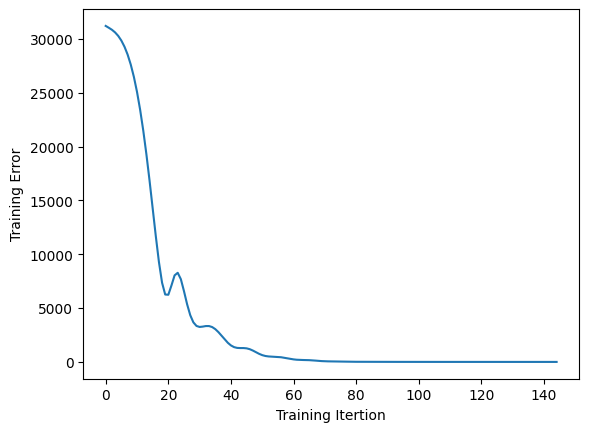

In [39]:
import matplotlib.pyplot as plt

if not retrieval:
  plt.plot(regr.loss_curve_);
  plt.xlabel("Training Itertion")
  plt.ylabel("Training Error")
  min(regr.loss_curve_)

Based on the above plot the model does seem converged / to have converged quite quckly.

Now lets test the model !!! (we will look at the root mean squared error in calories to begin with), its lazy we can do better. If you look at the median absolute error it does suggest theres some outliers in the test result, its worth seeing what the recipie for the worst performances is and to try and diagnose why this is not working 

In [24]:
delta_test= regr.predict(vec_X_test) - y_test[:smaller].flatten()
print(delta_test.shape)
rmse_test = np.sqrt(np.mean((delta_test) ** 2))
rmae_test = np.sqrt(np.median((delta_test) ** 2))

rmse_test, rmae_test

(10,)


(190.1329568315948, 119.80742622653804)

In [25]:
delta_train = regr.predict(vec_X_train) - y_train[:smaller].flatten()
print(delta_train.shape)
rmse_train = np.sqrt(np.mean((delta_train) ** 2))
rmae_train = np.sqrt(np.median((delta_train) ** 2))
rmse_train, rmae_train

(10,)


(0.0, 0.0)

<AxesSubplot: xlabel='rmse', ylabel='labels'>

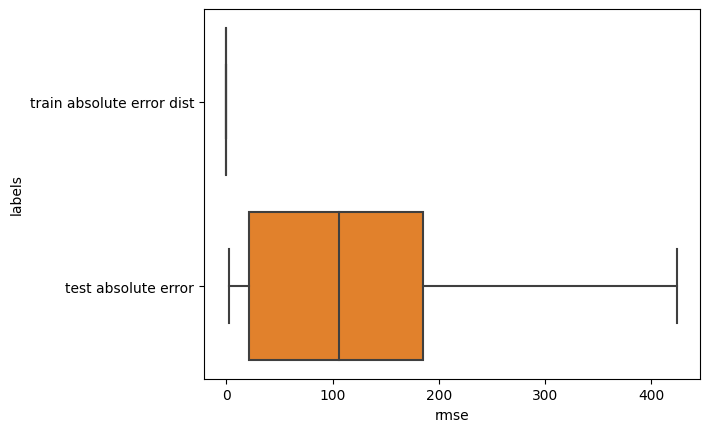

In [26]:
import seaborn as sns
import pandas as pd


labels = ["train absolute error dist"] * len(delta_train) + ["test absolute error"] * len(delta_test) 
rmse_train_all = list(np.abs(delta_train)) + list(np.abs(delta_test))

df = pd.DataFrame({
    "rmse": rmse_train_all,
    "labels": labels
})

sns.boxplot(data=df, x="rmse", y="labels")

This is the error in kCal per 100g , pretty easy quantity to interpret.

We can see that the test error is at 145 kcals per 100g whilst the train error is 20kcal per 100g thus this model does not generalise well (it overfits). Maybe we need: 

* Better recipie specific embeddings
* Maybe using image data is better
* The way we encoded recipies into sentences might have not been the smartest
* We could try training the model for longer.

# How do we use this for a new recipeie

For a new recipie we  need to first write a function that transforms it into a similar-ish sentence format to what we have used in training then we pass it through the transformer sentence embedder and the pass it through the trained model it for example:

In [27]:
ingredients_sentence = ["greasy-pizza, fish, fried-potatoes"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

array([208.87766481])

In [28]:
ingredients_sentence = ["broccoli, lettuce, water"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

array([171.31729511])

In [29]:
ingredients_sentence = ["onion, tomato, squash"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

array([252.14633061])

In [30]:
ingredients_sentence = ["tomato, spinach, ginger"]
vector = model.encode(ingredients_sentence)
prediction = regr.predict(vector)
prediction

array([255.56116713])



Think about the above results, they are not quite right and some are quite wrong/unintuitve thus it seems this model hasnt learned anything good unfortunately. 

Maybe:

* I processed the data wrong ?
* We need more data ?
* We need to train for longer

